In [0]:
# Referensi:
# https://becominghuman.ai/jump-start-with-linear-regression-using-pyspark-mllib-f7f1578a684a
# dataset: https://www.kaggle.com/rohankayan/years-of-experience-and-salary-dataset

Last Update

In [59]:
!date

Fri Feb  7 10:21:49 UTC 2020


Here is the code

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
!wget https://www.dropbox.com/s/fhf4aba59ey0i2r/salary_data.csv

--2020-02-07 08:01:54--  https://www.dropbox.com/s/fhf4aba59ey0i2r/salary_data.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fhf4aba59ey0i2r/salary_data.csv [following]
--2020-02-07 08:01:55--  https://www.dropbox.com/s/raw/fhf4aba59ey0i2r/salary_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1025d159dc1c853ceae41b7b06.dl.dropboxusercontent.com/cd/0/inline/AxpQfPUlnoMB-m3ep0M2gVRITMARhwUPavideXZPTBgZWSYjG941FFG71-cZhKwoiPBZ_HLmwnVI9bVRYm1neUybDuSLzzmt_wRv3Ml5108msfxwiWOpM4gfXoxVHRdPm7s/file# [following]
--2020-02-07 08:01:55--  https://uc1025d159dc1c853ceae41b7b06.dl.dropboxusercontent.com/cd/0/inline/AxpQfPUlnoMB-m3ep0M2gVRITMARhwUPavideXZPTBgZWSYjG941FFG71-cZhKwoiPBZ_HLmwnVI9bVRYm1neUybDuSLzzmt_wRv3Ml51

In [0]:
help(spark.read.csv)

In [0]:
df_dataset = spark.read.option("delimiter", "\t").csv(path='salary_data.csv', header = True, inferSchema = True)

In [17]:
df_dataset.show(6)

+---------------+-------+
|YearsExperience| Salary|
+---------------+-------+
|            1.1|39343.0|
|            1.3|46205.0|
|            1.5|37731.0|
|            2.0|43525.0|
|            2.2|39891.0|
|            2.9|56642.0|
+---------------+-------+
only showing top 6 rows



In [18]:
df_dataset.printSchema()

root
 |-- YearsExperience: double (nullable = true)
 |-- Salary: double (nullable = true)



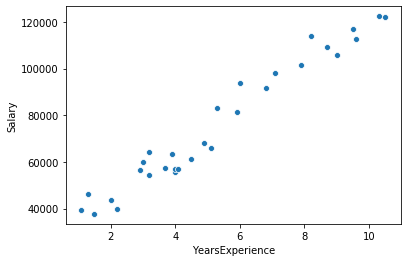

In [28]:
df = df_dataset.toPandas()
sns.scatterplot(x='YearsExperience', y='Salary', data=df)

In [0]:
data2 = df_dataset.select(df_dataset.YearsExperience, df_dataset.Salary.alias('label'))

In [21]:
data2.show(5)

+---------------+-------+
|YearsExperience|  label|
+---------------+-------+
|            1.1|39343.0|
|            1.3|46205.0|
|            1.5|37731.0|
|            2.0|43525.0|
|            2.2|39891.0|
+---------------+-------+
only showing top 5 rows



In [44]:
assembler = VectorAssembler().setInputCols(['YearsExperience',])\
                            .setOutputCol('features')
vec_data = assembler.transform(data2)

vec_data = vec_data.select(['features', 'label'])
vec_data.show(5)
vec_data.printSchema()


+--------+-------+
|features|  label|
+--------+-------+
|   [1.1]|39343.0|
|   [1.3]|46205.0|
|   [1.5]|37731.0|
|   [2.0]|43525.0|
|   [2.2]|39891.0|
+--------+-------+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [0]:
train_data, test_data = vec_data.randomSplit([0.7,0.3])

In [46]:
train_data.show(5)

+--------+-------+
|features|  label|
+--------+-------+
|   [1.1]|39343.0|
|   [1.3]|46205.0|
|   [1.5]|37731.0|
|   [2.2]|39891.0|
|   [3.0]|60150.0|
+--------+-------+
only showing top 5 rows



In [54]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
model = lr.fit(train_data)

print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
print("")
print ("##","Mean squared error: % .6f" % model.summary.meanSquaredError)
print ("##","RMSE: % .6f" % model.summary.rootMeanSquaredError)
print ("##","R-squared: %f" %  model.summary.r2)
print ("##","Total iterations: %i" % model.summary.totalIterations)

Coefficients: [9443.94990078018]
Intercept: 26139.66350205229

## Mean squared error:  40440538.539433
## RMSE:  6359.287581
## R-squared: 0.941949
## Total iterations: 1


R-squared : 0.94 artinya tingkat akurasi sekitar 94%

In [55]:
print("ObjectiveHistory: %s" % str(model.summary.objectiveHistory))
model.summary.residuals.show()

ObjectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
| 2814.9916070895124|
|  7788.201626933471|
|-2574.5883532225635|
| -7025.353283768694|
| 5678.4867956071685|
| -1915.303184548873|
|  8084.696815451127|
|  -6958.46310517301|
| -7778.858095251024|
| -7526.438055563107|
|-4477.0180158751755|
| -8274.807996031202|
|  6895.402023812756|
| 11136.637093266618|
| 1379.4771726424806|
| 10231.947311550233|
| 1128.9723611601366|
| -5553.212609073918|
|  1111.812440535985|
| -4166.582549542029|
+-------------------+



In [56]:
lr_predictions = model.transform(test_data)
lr_predictions.select("prediction","label","features").show(5)

+------------------+-------+--------+
|        prediction|  label|features|
+------------------+-------+--------+
| 45027.56330361265|43525.0|   [2.0]|
| 53527.11821431482|56642.0|   [2.9]|
|61082.278134938955|57189.0|   [3.7]|
|   62971.068115095|63218.0|   [3.9]|
| 63915.46310517301|55794.0|   [4.0]|
+------------------+-------+--------+
only showing top 5 rows



In [57]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                                   labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.982598


In [58]:
test_result = model.evaluate(test_data)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 3637.48
